In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import numpy as np
import pandas as pd
import torch
torch.cuda.empty_cache()

In [21]:
import os
os.chdir('/content/drive/MyDrive/health_fact')
# !unzip PUBHEALTH

### Sneak peek into the *dataset*

In [ ]:
health_fact=pd.read_csv('PUBHEALTH/train/data.tsv',sep='\t')
health_fact.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,


Note : We only consider the *main_text* and *claim* fields as input to our classification model

In [ ]:
# Clean the dataset
for i, r in health_fact.iterrows():
  if not r['label'] in set(labels_ids.keys()):
     health_fact.drop(index=i, inplace=True)
health_fact.dropna(axis=0,subset=['main_text'],inplace=True)
health_fact.dropna(axis=0,subset=['claim'],inplace=True)

In [ ]:
health_fact.shape

(9804, 9)

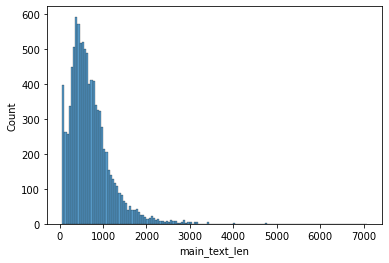

In [ ]:
health_fact['main_text_len'] =[len(row['main_text'].split(' ')) for _, row in health_fact.iterrows()]
import seaborn as sns

ax = sns.histplot(x="main_text_len",data=health_fact)

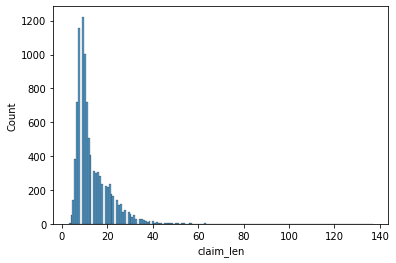

In [ ]:
health_fact['claim_len'] =[len(row['claim'].split(' ')) for _, row in health_fact.iterrows()]
ax = sns.histplot(x="claim_len",data=health_fact)

# Classification model

We see that the approximate num of tokens in majority of texts in the main_text column is >512 i.e., above the permissible num tokens in a models like Bert and GPT2, especially when we have 2 texts as input (main_text and claim). So, we use the Longformer-base-4096 model to fine tune on our dataset which has a maximum sequence length of 4096.

### We model the problem as follows:
Given : main_text, Claim (input encoding as: **$<s><mainText><\s><s><Claim><\s>$**)

Output: Label


In [63]:
import io
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          LongformerConfig,
                          LongformerTokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          LongformerForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs.
# Note: Model has been trained with total of 12 epochs with intermediate saving of models and not in one stretch (due to session timeout issues in colab)
epochs = 1

# Number of batches - depending on the max sequence length and GPU memory.
# We select a batch of size 1 to avoid cuda memory issues since we train on limited resources on Colab.
batch_size = 1

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 4096

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'allenai/longformer-base-4096'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'true': 0, 'false': 1,'unproven':2,'mixture':3}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

The standard input format to input two sentences to Longformer-base-4096 is  **$<s> \<mainText\> <\s><s> \<claim\> <\s>$**" .

The same can be achieved by inputting two sentences to the tokenizer as follows.

Example: tokenizer(main_text, claim)

In [64]:
class HealthFactDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):
    self.health_fact = pd.read_csv(path+'data.tsv',sep="\t")
    self.health_fact['main_text_len'] =[len(row['main_text'].split(' ')) if type(row['main_text'])==str else 0 for _, row in self.health_fact.iterrows() ]
    for i, r in self.health_fact.iterrows():
      if not r['label'] in set(labels_ids.keys()):
        self.health_fact.drop(index=i, inplace=True)
        continue
      if r['main_text_len']>3700:
        self.health_fact.drop(index=i,inplace=True)
    
    self.health_fact.dropna(axis=0,subset=['main_text'],inplace=True)
    self.health_fact.dropna(axis=0,subset=['claim'],inplace=True)

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.main_texts = []
    self.labels = []
    self.claims = []
    for i, row in self.health_fact.iterrows():

        self.main_texts.append(row['main_text'])
        self.claims.append(row['claim'])
        # Save encode labels.
        label=row['label']
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    
    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'main_text':self.main_texts[item],
            'claim': self.claims[item],
            'label':self.labels[item]}



class ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        The PyTorch DataLoader needs a collator function.
        This function allows the class object to be used as a function call.
        

        Arguments:

          item (:obj:`list`):
              List of main_texts, claims and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holds the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['main_text'] for sequence in sequences]

        # Get all claims from sequences list
        claims = [sequence['claim'] for sequence in sequences]

        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(texts,claims, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


# Train and Validation Functions

In [65]:
def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we would used for training.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Clear previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass 
    # This returns the loss because we have provided the `labels`.

    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [66]:
# Get model configuration.
print('Loading configuraiton...')
from transformers import LongformerConfig
model_config = LongformerConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = LongformerTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
# tokenizer.padding_side = "left"     
# Define PAD Token = EOS Token = 50256
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model_config.vocab_size=50266
# Get the actual model.
print('Loading model...')
model = LongformerForSequenceClassification.from_pretrained(pretrained_model_name_or_path='health_fact_classifier_27Oct', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cuda`


In [67]:
# Create data collator to encode text and labels into numbers.
import pandas as pd
classification_collator = ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = HealthFactDataset(path='PUBHEALTH/train/', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=classification_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

# print('Dealing with Validation...')
# # Create pytorch dataset.
valid_dataset =  HealthFactDataset(path='PUBHEALTH/dev/', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=classification_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 9780 examples!
Created `train_dataloader` with 9780 batches!
Created `valid_dataset` with 1213 examples!
Created `eval_dataloader` with 1213 batches!


In [68]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)
print(tokenizer.pad_token)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

[PAD]
Epoch


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/9780 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1213 [00:00<?, ?it/s]

  train_loss: 0.54601 - val_loss: 1.54676 - train_acc: 0.91483 - valid_acc: 0.78071


In [70]:
model.save_pretrained("health_fact_classifier_27Oct_final")

In [79]:
#test

# # # Create pytorch dataset.
test_dataset =  HealthFactDataset(path='PUBHEALTH/test/', 
                               use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=classification_collator)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
print("Test accuracy: %.3f"%(test_acc))

Test accuracy: 0.764


In [72]:
id2labels = {v:k for k, v in labels_ids.items()}

Average F1 score: 0.765


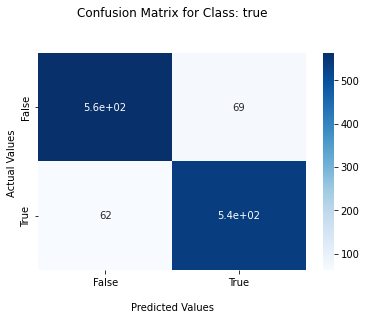

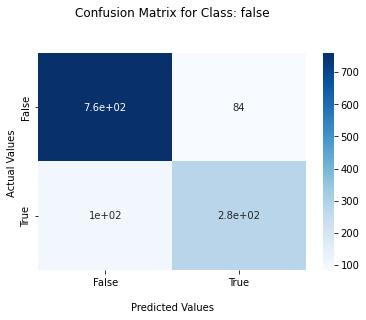

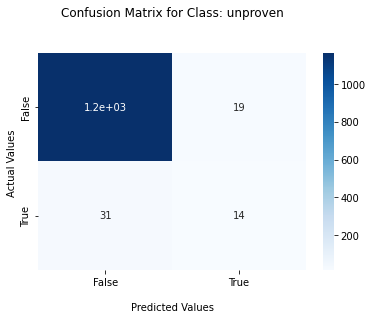

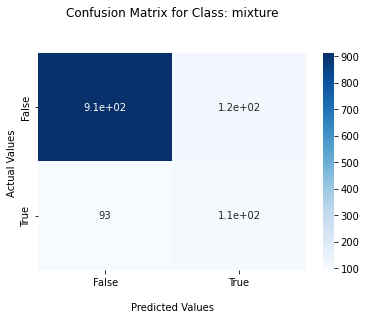

In [73]:
#Plot confusion matrix for each of the classes on the test set
from sklearn.metrics import multilabel_confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
print("Average F1 score: %.3f"%f1_score(test_labels,test_predict,average='weighted') )
cf_matrix_list = multilabel_confusion_matrix(test_labels,test_predict)

for i in range(len(id2labels)):
  ax = sns.heatmap(cf_matrix_list[i], annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix for Class: {}\n\n'.format(id2labels[i]));
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  plt.show()